# Lab 6: Motion and Neural Network Classification


In [2]:
import cv2
import numpy as np
import os

dataDir = 'images'

### 1. Optical Flow with Lucas-Kanade Algorithm

In [1]:
# Define a VideoCapture Object
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open camera")
    exit()

# Define maximum number of features to track
max_num_features = 100

# Create some random colors
color = np.random.randint(0, 255, (max_num_features, 3))

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, maxCorners=max_num_features, qualityLevel=0.3, minDistance=7, blockSize=7)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame...")
        break

    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS|cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]

    # Draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        frame = cv2.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
    img = cv2.add(frame, mask)

    cv2.imshow('frame', img)
    if cv2.waitKey(1) != -1:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

cap.release()
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

**Exercise 1.1**: Replace ShiTomasi feature detection by FAST feature detector.

In [ ]:
# Define a VideoCapture Object
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open camera")
    exit()

# Define maximum number of features to track
max_num_features = 100

# Create some random colors
color = np.random.randint(0, 255, (max_num_features, 3))

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
fast = cv2.FastFeatureDetector_create()
keypoints = fast.detect(old_gray, None)
p0 = np.array([kp.pt for kp in keypoints], dtype=np.float32).reshape(-1, 1, 2)


# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)
color = (0, 255, 0)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame...")
        break

    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS|cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]

    # Draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color, 2)
        frame = cv2.circle(frame, (int(a), int(b)), 5, color, -1)

    img = cv2.add(frame, mask)

    cv2.imshow('frame', img)
    if cv2.waitKey(1) != -1:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

cap.release()
cv2.destroyAllWindows()

# 2. Neural Networks

In this notebook we will learn how to train a simple Multilayer Perceptron for image classification using PyTorch.

[Click here to check guide to install PyTorch locally.](https://pytorch.org/get-started/locally/)

You can find additional information [here](https://pytorch.org/tutorials/beginner/basics/intro.html).


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm

## Load dataset

The torchvision package contains a few datasets. We will use the MNIST dataset of handwritten digits.

The dataset comes separated into training and test sets. We will further separate the test set into two smaller sets: validation and test.


In [2]:
# Define transformations that are applied to the image
data_aug = transforms.Compose([transforms.ToTensor()]) # ToTensor() transforms an image into a tensor, normalizing it into values between 0 and 1

# Load training data from MNIST into directory defined in "root"
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_aug,
)

# Load test data from MNIST into directory defined in "root"
validation_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=data_aug,
)

# Separate test images into validation (80%) and testing (20%)
indices = list(range(len(validation_data)))
np.random.shuffle(indices)

test_size = 0.2 * len(indices)
split = int(np.floor(test_size))
val_idx, test_idx = indices[split:], indices[:split]

val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.49MB/s]


Define a data loader that automatically fetches batches of images and their labels

In [3]:
batch_size = 64 # number of images loaded at each time
num_workers = 2 # how many processes are used to load the data

# Define data loaders for the train, test and validation data
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
validation_dataloader = DataLoader(validation_data, sampler=val_sampler, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(validation_data, sampler=test_sampler, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False)

## Visualize the Data

Directly using the dataset

In [4]:
# Get the first sample of the training data (contains an image and its label)

sample = training_data[0]

# Get image and print its dimensions
img = sample[0]
print(img.shape)

# Get label and print it
label = sample[1]
print(label)

torch.Size([1, 28, 28])
5


Iterating over the data loader

torch.Size([64, 1, 28, 28])
tensor([9, 7, 4, 0, 7, 4, 4, 9, 3, 2, 1, 0, 9, 9, 7, 9, 6, 5, 7, 2, 8, 1, 4, 1,
        1, 5, 3, 1, 5, 3, 3, 4, 1, 7, 0, 8, 4, 2, 0, 6, 9, 6, 9, 7, 0, 0, 0, 0,
        6, 1, 6, 0, 4, 8, 5, 0, 3, 3, 8, 4, 3, 5, 4, 6])


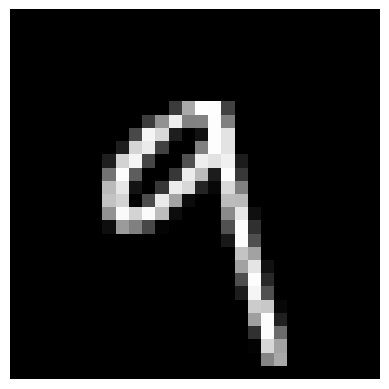

In [5]:
for batch in train_dataloader:
  # Get images of the batch and print their dimensions
  imgs = batch[0]
  print(imgs.shape)

  # Get labels of each image in the batch and print them
  labels = batch[1]
  print(labels)

  # Show first image of the batch
  plt.imshow(imgs[0][0,:,:], cmap='gray')
  plt.axis('off')
  plt.show()

  break

## Defining the model

**Exercise 2.1:** Create an MLP with the following structure:

1. Dense/linear layer that takes the images as a flattened input vector and generates an output of 512 of dimension.
2. ReLU activation layer
3. Dense/linear layer with 512 input and output
3. ReLU activation layer
4. Dense/linear layer with 10 output channels (10 classes of MNIST)

You can use PyTorch's layers: https://pytorch.org/docs/stable/nn.html (Conv2d, ReLU, Linear, MaxPool2d, Dropout, Flatten)

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.pipeline = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.pipeline(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (pipeline): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


**Exercise 2.2:** Interpret the implemented architecture and try to answer the following questions:

a) What is the shape (width, and # of channels) of the output tensor after the first layer?

b) And after the first 3 layers (dense+dense+dense)?

c) How many parameters (weights) does the model have? Contrary to Keras, PyTorch does not have an official method for counting the number of parameters of a model, but you can use [torchsummary](https://pypi.org/project/torch-summary/)

In [ ]:
# a) After the first layer the output tensor has a width of 512. Channels = 1 (?)
# b) After the first 3 layers (the three dense layers because ReLU is more like an activation layer) the shape has a width of 10 - same channels as previous
# c) (784 * 512 + 512) + (512 * 512 + 512) + (512 * 10 + 10) -> (channels_input * channels_output + biases (=channels_output))


In [9]:
!pip install torch-summary
from torchsummary import summary

summary(model, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 784]                 --
├─Sequential: 1-2                        [-1, 10]                  --
|    └─Linear: 2-1                       [-1, 512]                 401,920
|    └─ReLU: 2-2                         [-1, 512]                 --
|    └─Linear: 2-3                       [-1, 512]                 262,656
|    └─ReLU: 2-4                         [-1, 512]                 --
|    └─Linear: 2-5                       [-1, 10]                  5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
Total mult-adds (M): 1.34
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.55
Estimated Total Size (MB): 2.57


Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 784]                 --
├─Sequential: 1-2                        [-1, 10]                  --
|    └─Linear: 2-1                       [-1, 512]                 401,920
|    └─ReLU: 2-2                         [-1, 512]                 --
|    └─Linear: 2-3                       [-1, 512]                 262,656
|    └─ReLU: 2-4                         [-1, 512]                 --
|    └─Linear: 2-5                       [-1, 10]                  5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
Total mult-adds (M): 1.34
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.55
Estimated Total Size (MB): 2.57

## Train the model

In [11]:
# Define loss function
loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation

# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Define one iteration

In [12]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."

    # Get number of batches
    num_batches = len(dataloader)

    # Set model to train mode or evaluation mode
    if is_train:
      model.train()
    else:
      model.eval()

    # Define variables to save predictions and labels during the epoch
    total_loss = 0.0
    preds = []
    labels = []

    # Enable/disable gradients based on whether the model is in train or evaluation mode
    with torch.set_grad_enabled(is_train):

      # Analyse all batches
      for batch, (X, y) in enumerate(tqdm(dataloader)):

          # Put data in same device as model (GPU or CPU)
          X, y = X.to(device), y.to(device)

          # Forward pass to obtain prediction of the model
          pred = model(X)

          # Compute loss between prediction and ground-truth
          loss = loss_fn(pred, y)

          # Backward pass
          if is_train:
            # Reset gradients in optimizer
            optimizer.zero_grad()
            # Calculate gradients by backpropagating loss
            loss.backward()
            # Update model weights based on the calculated gradients
            optimizer.step()

          # Apply softmax activation to obtain final prediction
          probs = F.softmax(pred, dim=1)
          final_pred = torch.argmax(probs, dim=1)

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          # Add predictions
          preds.extend(final_pred.cpu().numpy())
          labels.extend(y.cpu().numpy())

    return total_loss / num_batches, accuracy_score(labels, preds)

Define training cycle

In [16]:
num_epochs = 10
train_history = {'loss': [], 'accuracy': []}
val_history = {'loss': [], 'accuracy': []}
best_val_loss = np.inf

# Training cycle
print("Start training...")
for t in range(num_epochs):
    print(f"\nEpoch {t+1}")

    # Train model for one iteration on training data
    train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
    print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")

    # Evaluate model on validation data
    val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
    print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

    # Save model when validation loss improves
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, 'best_model.pth')

    # Save latest model
    save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
    torch.save(save_dict, 'latest_model.pth')

    # Save training history for plotting purposes
    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_acc)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_acc)

print("Finished")

Start training...

Epoch 1


100%|██████████| 937/937 [00:08<00:00, 113.73it/s]


Train loss: 0.616 	 Train acc: 0.846


100%|██████████| 125/125 [00:01<00:00, 88.28it/s] 


Val loss: 0.571 	 Val acc: 0.855

Epoch 2


100%|██████████| 937/937 [00:07<00:00, 123.22it/s]


Train loss: 0.569 	 Train acc: 0.855


100%|██████████| 125/125 [00:00<00:00, 125.75it/s]


Val loss: 0.530 	 Val acc: 0.862

Epoch 3


100%|██████████| 937/937 [00:08<00:00, 105.91it/s]


Train loss: 0.533 	 Train acc: 0.862


100%|██████████| 125/125 [00:00<00:00, 127.03it/s]


Val loss: 0.498 	 Val acc: 0.870

Epoch 4


100%|██████████| 937/937 [00:08<00:00, 110.90it/s]


Train loss: 0.504 	 Train acc: 0.868


100%|██████████| 125/125 [00:00<00:00, 125.59it/s]


Val loss: 0.471 	 Val acc: 0.877

Epoch 5


100%|██████████| 937/937 [00:07<00:00, 119.91it/s]


Train loss: 0.480 	 Train acc: 0.872


100%|██████████| 125/125 [00:01<00:00, 83.06it/s]


Val loss: 0.450 	 Val acc: 0.881

Epoch 6


100%|██████████| 937/937 [00:07<00:00, 123.64it/s]


Train loss: 0.460 	 Train acc: 0.876


100%|██████████| 125/125 [00:00<00:00, 125.28it/s]


Val loss: 0.432 	 Val acc: 0.885

Epoch 7


100%|██████████| 937/937 [00:08<00:00, 113.03it/s]


Train loss: 0.444 	 Train acc: 0.880


100%|██████████| 125/125 [00:01<00:00, 118.62it/s]


Val loss: 0.417 	 Val acc: 0.888

Epoch 8


100%|██████████| 937/937 [00:08<00:00, 112.75it/s]


Train loss: 0.429 	 Train acc: 0.883


100%|██████████| 125/125 [00:01<00:00, 123.54it/s]


Val loss: 0.404 	 Val acc: 0.890

Epoch 9


100%|██████████| 937/937 [00:07<00:00, 122.29it/s]


Train loss: 0.417 	 Train acc: 0.886


100%|██████████| 125/125 [00:01<00:00, 85.90it/s]


Val loss: 0.393 	 Val acc: 0.892

Epoch 10


100%|██████████| 937/937 [00:07<00:00, 120.73it/s]


Train loss: 0.406 	 Train acc: 0.889


100%|██████████| 125/125 [00:00<00:00, 129.10it/s]

Val loss: 0.383 	 Val acc: 0.895
Finished


## Analyse training evolution

**Exercise 2.3:** Plot loss and accuracy throughout training on train and validation data

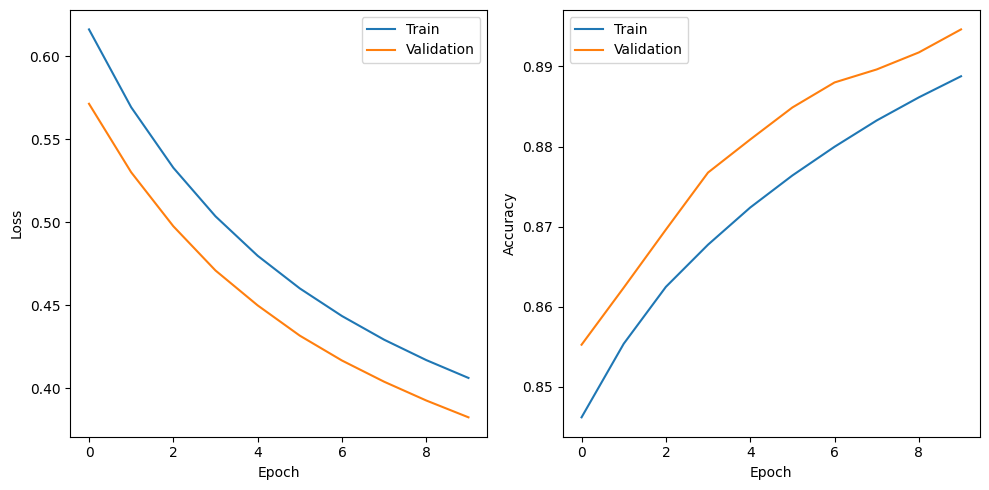

In [17]:
# prompt: Plot loss and accuracy throughout training on train and validation data

plt.figure(figsize=(10, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_history['loss'], label='Train')
plt.plot(val_history['loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_history['accuracy'], label='Train')
plt.plot(val_history['accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Test the model

**Exercise 2.4:** Evaluate the model in the test set

In [ ]:
# TODO

In [18]:
def showErrors(model, dataloader, num_examples=20):
    plt.figure(figsize=(15, 15))

    for ind, (X, y) in enumerate(dataloader):
      if ind >= 20: break
      X, y = X.to(device), y.to(device)
      pred = model(X)
      probs = F.softmax(pred, dim=1)
      final_pred = torch.argmax(probs, dim=1)

      plt.subplot(10, 10, ind + 1)
      plt.axis("off")
      plt.text(0, -1, y[0].item(), fontsize=14, color='green') # correct
      plt.text(8, -1, final_pred[0].item(), fontsize=14, color='red')  # predicted
      plt.imshow(X[0][0,:,:].cpu(), cmap='gray')
    plt.show()

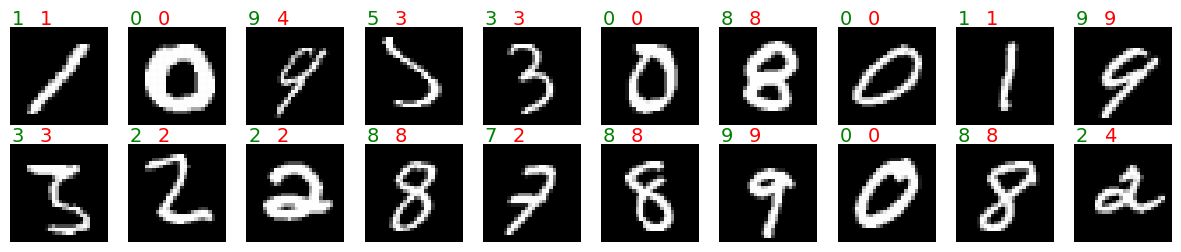

In [19]:
showErrors(model, test_dataloader)

## Additional Challenges

a) As the test accuracy should show, the MNIST dataset is not very challenging, change the code to use Fashion-MNIST and compare the results.

b) Do the same for the CIFAR10 (or CIFAR100) dataset. Note that, in this case, each image is a 32x32 color image; convert it to grayscale or concatenate the RGB channels in one single vector (e.g. using the reshape method).

c) The test accuracy for CIFAR is significantly worse. Try improving the results by using: 1) a deeper architecture, and 2) a different optmizer.

You can load the datasets from [here](https://pytorch.org/vision/stable/datasets.html).
